<a href="https://colab.research.google.com/github/Deluarh/ml_time_series_test/blob/master/stock_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import pandas as pd
import numpy as np

%matplotlib inline
from matplotlib import pyplot as plt

import random
import math

import tensorflow as tf
from tensorflow.contrib import rnn
from sklearn import linear_model

import time

In [0]:
chart_data_full_300 = pd.read_json("./chart_data_full_300.json")

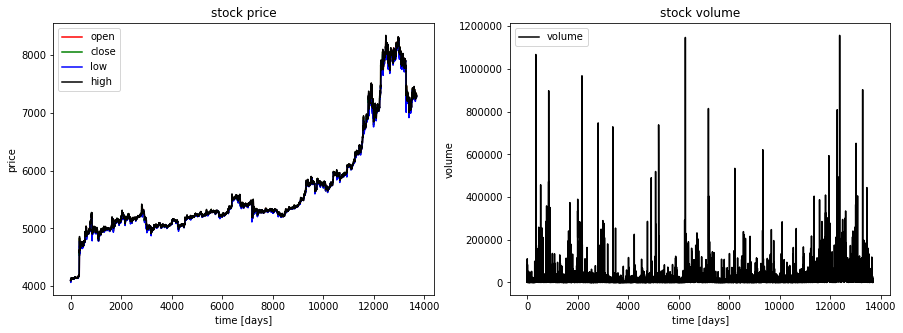

In [21]:
plt.figure(figsize=(15, 5));
plt.subplot(1,2,1);
plt.plot(chart_data_full_300.open.values, color='red', label='open')
plt.plot(chart_data_full_300.close.values, color='green', label='close')
plt.plot(chart_data_full_300.low.values, color='blue', label='low')
plt.plot(chart_data_full_300.high.values, color='black', label='high')
plt.title('stock price')
plt.xlabel('time [days]')
plt.ylabel('price')
plt.legend(loc='best')
#plt.show()

plt.subplot(1,2,2);
plt.plot(chart_data_full_300.volume.values, color='black', label='volume')
plt.title('stock volume')
plt.xlabel('time [days]')
plt.ylabel('volume')
plt.legend(loc='best');

In [0]:
def plot_prices(prices):
    plt.title('Opening stock prices')
    plt.xlabel('day')
    plt.ylabel('price ($)')
    plt.plot(prices)
    plt.savefig('prices.png')
    plt.show()

In [0]:
#стратегия принятия решения
class DecisionPolicy:
    def select_action(self, current_state, step):
        pass

    def update_q(self, state, action, reward, next_state):
        pass


In [0]:
class QLearningDecisionPolicy(DecisionPolicy):
    def __init__(self, actions, input_dim):
        
        self.epsilon = 0.95#0.95 # вероятность слуайного выбора #затухающая вероятность?
        self.eps_min = 0.90
        self.eps_max = 0.95
        self.eps_decay_steps = 20000
        self.global_step = 0
        
        self.gamma = 0.3
        self.actions = actions #выборы
        output_dim = len(actions) # ['Buy', 'Sell', 'Hold']
        h1_dim = 20 # число скрытых узлов. задать динамически?

        self.x = tf.placeholder(tf.float32, [None, input_dim])
        self.y = tf.placeholder(tf.float32, [output_dim])
        
        W1 = tf.Variable(tf.random_normal([input_dim, h1_dim]))
        b1 = tf.Variable(tf.constant(0.1, shape=[h1_dim]))
        h1 = tf.nn.relu(tf.matmul(self.x, W1) + b1)
        
        W2 = tf.Variable(tf.random_normal([h1_dim, output_dim]))
        b2 = tf.Variable(tf.constant(0.1, shape=[output_dim]))
        self.q = tf.nn.relu(tf.matmul(h1, W2) + b2)

        loss = tf.square(self.y - self.q)
        self.train_op = tf.train.AdamOptimizer(0.001).minimize(loss)
        
        self.sess = tf.Session()
        self.sess.run(tf.global_variables_initializer())
        self.saver = tf.train.Saver()
    
    def select_action(self, current_state, step):
        #threshold = min(self.epsilon, step / 1000.)
        
        self.global_step += 1
        threshold = max (self.eps_min, self.eps_max - (self.eps_max - self.eps_min) *
                         self.global_step /self.eps_decay_steps)
        if random.random() < threshold:
            # Exploit best option with probability epsilon
            #tf.get_variable_scope().reuse_variables()
            #if self.global_step > 4:
             # self.saver.restore(self.sess, './q_model.ckpt')
            action_q_vals = self.sess.run(self.q, feed_dict={self.x: current_state})
            action_idx = np.argmax(action_q_vals)  # TODO: replace w/ tensorflow's argmax
            action = self.actions[action_idx]
        else:
            # Explore random option with probability 1 - epsilon
            action = self.actions[random.randint(0, len(self.actions) - 1)] #?
        return action

    def update_q(self, state, action, reward, next_state):
        action_q_vals = self.sess.run(self.q, feed_dict={self.x: state}) #предсказание текущее
        next_action_q_vals = self.sess.run(self.q, feed_dict={self.x: next_state}) # следующее предсказание
        next_action_idx = np.argmax(next_action_q_vals) #выюор действия 
        current_action_idx = self.actions.index(action) #
        action_q_vals[0, current_action_idx] = reward + self.gamma * next_action_q_vals[0, next_action_idx]
        action_q_vals = np.squeeze(np.asarray(action_q_vals))
        self.sess.run(self.train_op, feed_dict={self.x: state, self.y: action_q_vals})
        #save_path = self.saver.save(self.sess, './q_model.ckpt')

In [0]:
def money_management(budget, price ):
    k = 0.3
    free_money = budget * k
    return free_money // price

def run_simulation(policy, initial_budget, initial_num_stocks, prices, hist, debug=False):
    budget = initial_budget #бюджет
    num_stocks = initial_num_stocks #количество акций
    share_value = 0 # стоимость акции
    transitions = list() #переходы?
    log_transitions = pd.DataFrame(columns=['prices', 'budget', 'num_stocks', 'action', 'date'])
    position = 0 
    
    log_transitions.loc[1] = 1 #?
    for i in range(len(prices) - hist - 1):
        #if i % 5000 == 0:
         #   print('progress {:.2f}%'.format(float(100*i) / (len(prices) - hist - 1)))
            
        #current_state = np.asmatrix(np.hstack((prices[i:i+hist], budget, num_stocks)))
        current_state = np.asmatrix(np.hstack((prices[i:i+hist], budget, position)))
        current_portfolio = budget + num_stocks * share_value
        action = policy.select_action(current_state, i)
        
        share_value = float(prices[i + hist])
        

        if action == 'Buy' and (position == 0 or position == -1) :# and budget >= share_value:
            transaction_volume = money_management(budget, share_value) # объем сделки
            budget -= share_value * transaction_volume
            num_stocks += transaction_volume
            if position == 0:
                position = 1
            else:
                position = 0
                
            #log_transitions.loc[i]= [share_value, budget, num_stocks, action, i]
            
        elif action == 'Sell' and (position == 0 or position == 1):# and num_stocks > 0: 
            transaction_volume = money_management(budget, share_value) # объем сделки
            budget += share_value * transaction_volume
            num_stocks -= transaction_volume
            if position == 0:
                position = -1
            else:
                position = 0
            #log_transitions.loc[i]= [share_value, budget, num_stocks, action, i]
        else:
            action = 'Hold'
            #log_transitions.loc[i]= [share_value, budget, num_stocks, action, i]
        
        
        new_portfolio = budget + num_stocks * share_value
        reward = new_portfolio - current_portfolio # выгода
        #next_state = np.asmatrix(np.hstack((prices[i+1:i+hist+1], budget, num_stocks)))#добавить адаптивность окна
        next_state = np.asmatrix(np.hstack((prices[i+1:i+hist+1], budget, position)))#добавить адаптивность окна
        #transitions.append((current_state, action, reward, next_state))
        policy.update_q(current_state, action, reward, next_state)

    portfolio = budget + num_stocks * share_value

    print('${}\t{} shares'.format(budget, num_stocks))
    return portfolio, log_transitions

In [0]:
def run_simulations(policy, budget, num_stocks, prices, hist):
    num_tries = 5
    final_portfolios = list()
    transitions_list = list()
    for i in range(num_tries):
        print('Running simulation {}...'.format(i + 1))
        start_time = time.process_time() 
        final_portfolio, transitions = run_simulation(policy, budget, num_stocks, prices, hist)
        print("--- %s seconds ---" % ("{0:.1f}".format(time.process_time() - start_time )))
        final_portfolios.append(final_portfolio)
        print('Final portfolio: ${}'.format(final_portfolio))
        print("доходность = " + str("{0:.1f}".format((final_portfolio * 100 / budget) - 100.0)) + '%')
        print("доходность в день = " + str("{0:.1f}".format(((final_portfolio * 100 / budget) - 100.0)/47) + '%')) 
        transitions_list.append(transitions)
       
    plt.title('Final Portfolio Value')
    plt.xlabel('Simulation #')
    plt.ylabel('Net worth')
    plt.plot(final_portfolios)
    plt.show()
    return transitions_list

In [0]:
actions = ['Buy', 'Sell', 'Hold']
hist = 20 #200?
policy = QLearningDecisionPolicy(actions, hist + 2)

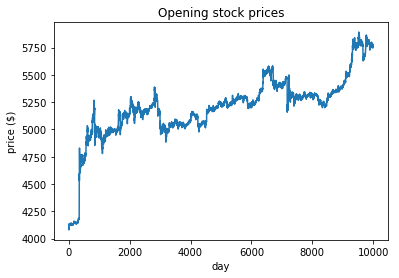

In [27]:
prices = chart_data_full_300.loc[:10000,'close' ]
plot_prices(prices)
budget = 1000000.0
num_stocks = 0

Running simulation 1...
$18862.96951728034	224.0 shares
--- 27.5 seconds ---
Final portfolio: $1311507.3671425604
доходность = 31.2%
доходность в день = 0.7%
Running simulation 2...
$23030.656062670016	225.0 shares
--- 27.2 seconds ---
Final portfolio: $1321445.78760592
доходность = 32.1%
доходность в день = 0.7%
Running simulation 3...
$23437.774256169996	227.0 shares
--- 27.2 seconds ---
Final portfolio: $1333394.37363536
доходность = 33.3%
доходность в день = 0.7%
Running simulation 4...
$20311.779574549964	226.0 shares
--- 27.1 seconds ---
Final portfolio: $1324497.64503577
доходность = 32.4%
доходность в день = 0.7%
Running simulation 5...
$24332.582834270346	225.0 shares
--- 28.9 seconds ---
Final portfolio: $1322747.7143775204
доходность = 32.3%
доходность в день = 0.7%


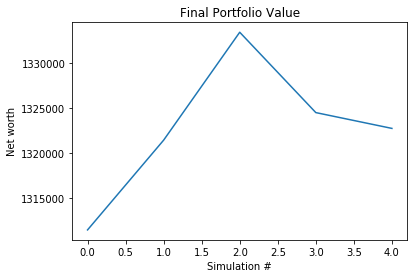

In [29]:
transitions_list = run_simulations(policy, budget, num_stocks, prices, hist)

In [33]:
i = 1
sell = transitions_list[i].loc[transitions_list[i]['action'] != 'Buy']
buy = transitions_list[i].loc[transitions_list[i]['action'] == 'Buy']
hold = transitions_list[i].loc[transitions_list[i]['action'] == 'hold']

print(sell.shape)
print(buy.shape)
print(hold.shape)

(7777, 5)
(2213, 5)
(0, 5)


In [11]:
final_portfolio, transitions = run_simulation(policy, budget, num_stocks, prices, hist)

INFO:tensorflow:Restoring parameters from ./q_model.ckpt
INFO:tensorflow:Restoring parameters from ./q_model.ckpt
INFO:tensorflow:Restoring parameters from ./q_model.ckpt
INFO:tensorflow:Restoring parameters from ./q_model.ckpt
INFO:tensorflow:Restoring parameters from ./q_model.ckpt
INFO:tensorflow:Restoring parameters from ./q_model.ckpt
INFO:tensorflow:Restoring parameters from ./q_model.ckpt
INFO:tensorflow:Restoring parameters from ./q_model.ckpt
INFO:tensorflow:Restoring parameters from ./q_model.ckpt
INFO:tensorflow:Restoring parameters from ./q_model.ckpt
INFO:tensorflow:Restoring parameters from ./q_model.ckpt
$11116.02129028993	239.0 shares


Final portfolio: $1390321.42768512
доходность = 39.0%
доходность в день = 0.8%


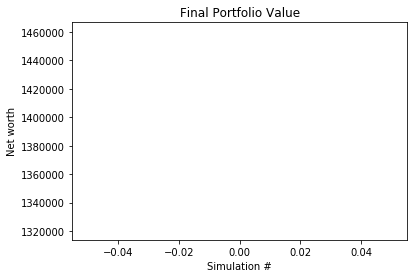

In [14]:
print('Final portfolio: ${}'.format(final_portfolio))
print("доходность = " + str("{0:.1f}".format((final_portfolio * 100 / budget) - 100.0)) + '%')
print("доходность в день = " + str("{0:.1f}".format(((final_portfolio * 100 / budget) - 100.0)/47) + '%')) 
plt.title('Final Portfolio Value')
plt.xlabel('Simulation #')
plt.ylabel('Net worth')
plt.plot(final_portfolio)
plt.show()

In [0]:
import numpy as np
import pandas as pd
import math
import sklearn
import sklearn.preprocessing
import datetime
import os
import matplotlib.pyplot as plt
import tensorflow as tf

# split data in 80%/10%/10% train/validation/test sets
valid_set_size_percentage = 10 
test_set_size_percentage = 10 

In [0]:
# нормализация -1, 1
def normalize_data(df):
    min_max_scaler = sklearn.preprocessing.MinMaxScaler()
    df['open'] = min_max_scaler.fit_transform(df.open.values.reshape(-1,1))
    df['high'] = min_max_scaler.fit_transform(df.high.values.reshape(-1,1))
    df['low'] = min_max_scaler.fit_transform(df.low.values.reshape(-1,1))
    df['close'] = min_max_scaler.fit_transform(df['close'].values.reshape(-1,1))
    return df

# function to create train, validation, test data given stock data and sequence length
def load_data(stock, seq_len):
    data_raw = stock.as_matrix() # convert to numpy array
    data = []
    
    # create all possible sequences of length seq_len
    for index in range(len(data_raw) - seq_len): 
        data.append(data_raw[index: index + seq_len])
    
    data = np.array(data);
    valid_set_size = int(np.round(valid_set_size_percentage/100*data.shape[0]));  
    test_set_size = int(np.round(test_set_size_percentage/100*data.shape[0]));
    train_set_size = data.shape[0] - (valid_set_size + test_set_size);
    
    x_train = data[:train_set_size,:-1,:]
    y_train = data[:train_set_size,-1,:]
    
    x_valid = data[train_set_size:train_set_size+valid_set_size,:-1,:]
    y_valid = data[train_set_size:train_set_size+valid_set_size,-1,:]
    
    x_test = data[train_set_size+valid_set_size:,:-1,:]
    y_test = data[train_set_size+valid_set_size:,-1,:]
    
    return [x_train, y_train, x_valid, y_valid, x_test, y_test]


In [108]:
df_stock = pd.DataFrame(columns=['close','high', 'low', 'open'])
df_stock['close'] = pd.Series(chart_data_full_300['close'].values)
df_stock['high'] = pd.Series(chart_data_full_300['high'].values)
df_stock['low'] = pd.Series(chart_data_full_300['low'].values)
df_stock['open'] = pd.Series(chart_data_full_300['open'].values)
# нормализация
df_stock_norm = df_stock.copy()
df_stock_norm = normalize_data(df_stock_norm)

# тестовые наборы
seq_len = 20 # длинна последовательности
x_train, y_train, x_valid, y_valid, x_test, y_test = load_data(df_stock_norm, seq_len)
print('x_train.shape = ',x_train.shape)
print('y_train.shape = ', y_train.shape)
print('x_valid.shape = ',x_valid.shape)
print('y_valid.shape = ', y_valid.shape)
print('x_test.shape = ', x_test.shape)
print('y_test.shape = ',y_test.shape)

x_train.shape =  (10940, 19, 4)
y_train.shape =  (10940, 4)
x_valid.shape =  (1368, 19, 4)
y_valid.shape =  (1368, 4)
x_test.shape =  (1368, 19, 4)
y_test.shape =  (1368, 4)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:11: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  # This is added back by InteractiveShellApp.init_path()


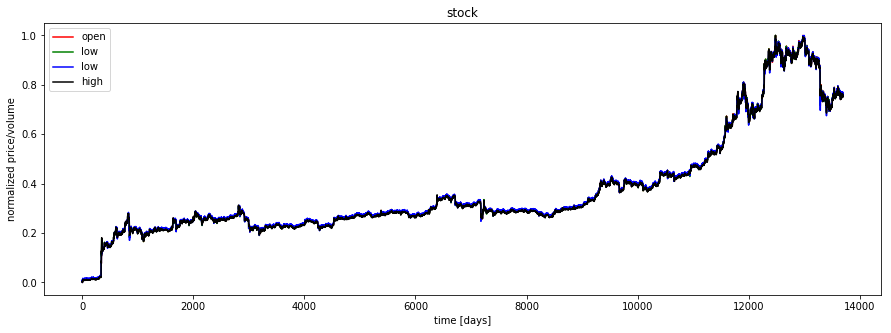

In [109]:
plt.figure(figsize=(15, 5));
plt.plot(df_stock_norm.open.values, color='red', label='open')
plt.plot(df_stock_norm.close.values, color='green', label='low')
plt.plot(df_stock_norm.low.values, color='blue', label='low')
plt.plot(df_stock_norm.high.values, color='black', label='high')
#plt.plot(df_stock_norm.volume.values, color='gray', label='volume')
plt.title('stock')
plt.xlabel('time [days]')
plt.ylabel('normalized price/volume')
plt.legend(loc='best')
plt.show()

In [0]:
index_in_epoch = 0;
perm_array  = np.arange(x_train.shape[0])
np.random.shuffle(perm_array)

# function to get the next batch
def get_next_batch(batch_size):
    global index_in_epoch, x_train, perm_array   
    start = index_in_epoch
    index_in_epoch += batch_size
    
    if index_in_epoch > x_train.shape[0]:
        np.random.shuffle(perm_array) # shuffle permutation array
        start = 0 # start next epoch
        index_in_epoch = batch_size
        
    end = index_in_epoch
    return x_train[perm_array[start:end]], y_train[perm_array[start:end]]

# parameters
class RNN:
    def __init__(self):

        tf.reset_default_graph()
        
        n_steps = seq_len-1 
        n_inputs = 4 
        n_neurons = 200 
        n_outputs = 4
        n_layers = 2
        learning_rate = 0.001
        
        X = tf.placeholder(tf.float32, [None, n_steps, n_inputs])
        y = tf.placeholder(tf.float32, [None, n_outputs])
# use Basic RNN Cell
#layers = [tf.contrib.rnn.BasicRNNCell(num_units=n_neurons, activation=tf.nn.elu)
#          for layer in range(n_layers)]

# use Basic LSTM Cell 
#layers = [tf.contrib.rnn.BasicLSTMCell(num_units=n_neurons, activation=tf.nn.elu)
#          for layer in range(n_layers)]

# use LSTM Cell with peephole connections
#layers = [tf.contrib.rnn.LSTMCell(num_units=n_neurons, 
#                                  activation=tf.nn.leaky_relu, use_peepholes = True)
#          for layer in range(n_layers)]

# use GRU cell
        layers = [tf.contrib.rnn.GRUCell(num_units=n_neurons, activation=tf.nn.leaky_relu)
                  for layer in range(n_layers)]
                                                                     
        multi_layer_cell = tf.contrib.rnn.MultiRNNCell(layers)
        rnn_outputs, states = tf.nn.dynamic_rnn(multi_layer_cell, X, dtype=tf.float32)

        stacked_rnn_outputs = tf.reshape(rnn_outputs, [-1, n_neurons]) 
        stacked_outputs = tf.layers.dense(stacked_rnn_outputs, n_outputs)
        self.outputs = tf.reshape(stacked_outputs, [-1, n_steps, n_outputs])
        self.outputs = outputs[:,n_steps-1,:] # keep only last output of sequence
                                              
        loss = tf.reduce_mean(tf.square(outputs - y)) # loss function = mean squared error 
        optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate) 
        self.training_op = optimizer.minimize(loss)
        
        self.sess = tf.Session()
        self.sess.run(tf.global_variables_initializer())
        self.saver = tf.train.Saver()
    
    
    def select_action(self, x_train):
        tf.get_variable_scope().reuse_variables()
        self.saver.restore(sess, './model.ckpt')
        sess.run(self.outputs, feed_dict={X: x_train})
        return action

    def fit(self,x_batch, y_batch):
        self.sess.run(self.training_op, feed_dict={X: x_batch, y: y_batch}) 
        save_path = self.saver.save(sess, 'model.ckpt')
        print('Model saved to {}'.format(save_path))

batch_size = 50
n_epochs = 10 
train_set_size = x_train.shape[0]
test_set_size = x_test.shape[0]

#обучение
model = RNN()
for iteration in range(int(n_epochs*train_set_size/batch_size)):
    x_batch, y_batch = get_next_batch(batch_size) # fetch the next training batch
    model.fit(x_batch, y_batch)
    if iteration % int(5*train_set_size/batch_size) == 0:
        mse_train = loss.eval(feed_dict={X: x_train, y: y_train}) 
        mse_valid = loss.eval(feed_dict={X: x_valid, y: y_valid}) 
        print('%.2f epochs: MSE train/valid = %.6f/%.6f'%(
            iteration*batch_size/train_set_size, mse_train, mse_valid))


In [0]:
y_train_pred = model.predict(x_train)
y_valid_pred =  model.predict(x_valid)
y_test_pred = model.predict(x_test) 

In [0]:
## Basic Cell RNN in tensorflow

index_in_epoch = 0;
perm_array  = np.arange(x_train.shape[0]) 
np.random.shuffle(perm_array)

# function to get the next batch
def get_next_batch(batch_size):
    global index_in_epoch, x_train, perm_array   
    start = index_in_epoch
    index_in_epoch += batch_size
    
    if index_in_epoch > x_train.shape[0]:
        np.random.shuffle(perm_array) # shuffle permutation array
        start = 0 # start next epoch
        index_in_epoch = batch_size
        
    end = index_in_epoch
    return x_train[perm_array[start:end]], y_train[perm_array[start:end]]

# parameters
n_steps = seq_len-1 # кол свечей

n_inputs = 4 # свеча. 4 измерения
n_neurons = 200 
n_outputs = 4 # свеча. 4 измерения
n_layers = 2 #кол слоев
learning_rate = 0.001 

batch_size = 50
n_epochs = 100 
train_set_size = x_train.shape[0]
test_set_size = x_test.shape[0]

tf.reset_default_graph() # сброс графа 
X = tf.placeholder(tf.float32, [None, n_steps, n_inputs])
y = tf.placeholder(tf.float32, [None, n_outputs])


# GRU
layers = [tf.contrib.rnn.GRUCell(num_units=n_neurons, activation=tf.nn.leaky_relu)
          for layer in range(n_layers)]
                                                                     
multi_layer_cell = tf.contrib.rnn.MultiRNNCell(layers)
rnn_outputs, states = tf.nn.dynamic_rnn(multi_layer_cell, X, dtype=tf.float32)

stacked_rnn_outputs = tf.reshape(rnn_outputs, [-1, n_neurons]) 
stacked_outputs = tf.layers.dense(stacked_rnn_outputs, n_outputs)
outputs = tf.reshape(stacked_outputs, [-1, n_steps, n_outputs])
outputs = outputs[:,n_steps-1,:] # keep only last output of sequence
                                              
loss = tf.reduce_mean(tf.square(outputs - y)) # loss function = mean squared error 
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate) 
training_op = optimizer.minimize(loss)
      
saver = tf.train.Saver()

    

In [0]:
# обучение
with tf.Session() as sess: 
    sess.run(tf.global_variables_initializer())
    for iteration in range(int(n_epochs*train_set_size/batch_size)):
        x_batch, y_batch = get_next_batch(batch_size) # fetch the next training batch
        sess.run(training_op, feed_dict={X: x_batch, y: y_batch}) 
        if iteration % int(5*train_set_size/batch_size) == 0:
            mse_train = loss.eval(feed_dict={X: x_train, y: y_train}) 
            mse_valid = loss.eval(feed_dict={X: x_valid, y: y_valid}) 
            print('%.2f epochs: MSE train/valid = %.6f/%.6f'%(
                iteration*batch_size/train_set_size, mse_train, mse_valid))
            save_path = saver.save(sess, 'model.ckpt')
            print('Model saved to {}'.format(save_path))
    save_path = saver.save(sess, 'model.ckpt')
    print('Model saved to {}'.format(save_path))

In [0]:
# предсказание 
def prediction(test_x):
  with tf.Session() as sess:
    tf.get_variable_scope().reuse_variables()
    saver.restore(sess, './model.ckpt')
    output = sess.run(outputs, feed_dict={X: test_x})
    #output = sess.run(self.model(), feed_dict={self.x: test_x})
    return output
  

In [114]:
y_train_pred = prediction(x_train)
y_valid_pred =  prediction(x_valid)
y_test_pred = prediction(x_test) 

INFO:tensorflow:Restoring parameters from ./model.ckpt
INFO:tensorflow:Restoring parameters from ./model.ckpt
INFO:tensorflow:Restoring parameters from ./model.ckpt


correct sign prediction for close - open price for train/valid/test: 0.96/0.85/0.40


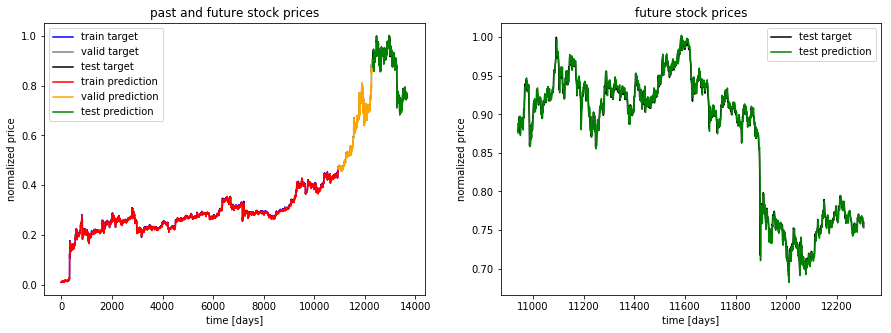

In [115]:
ft = 0 # 0 = open, 1 = close, 2 = highest, 3 = lowest

## show predictions
plt.figure(figsize=(15, 5));
plt.subplot(1,2,1);

plt.plot(np.arange(y_train.shape[0]), y_train[:,ft], color='blue', label='train target')

plt.plot(np.arange(y_train.shape[0], y_train.shape[0]+y_valid.shape[0]), y_valid[:,ft],
         color='gray', label='valid target')

plt.plot(np.arange(y_train.shape[0]+y_valid.shape[0],
                   y_train.shape[0]+y_test.shape[0]+y_test.shape[0]),
         y_test[:,ft], color='black', label='test target')

plt.plot(np.arange(y_train_pred.shape[0]),y_train_pred[:,ft], color='red',
         label='train prediction')

plt.plot(np.arange(y_train_pred.shape[0], y_train_pred.shape[0]+y_valid_pred.shape[0]),
         y_valid_pred[:,ft], color='orange', label='valid prediction')

plt.plot(np.arange(y_train_pred.shape[0]+y_valid_pred.shape[0],
                   y_train_pred.shape[0]+y_valid_pred.shape[0]+y_test_pred.shape[0]),
         y_test_pred[:,ft], color='green', label='test prediction')

plt.title('past and future stock prices')
plt.xlabel('time [days]')
plt.ylabel('normalized price')
plt.legend(loc='best');

plt.subplot(1,2,2);

plt.plot(np.arange(y_train.shape[0], y_train.shape[0]+y_test.shape[0]),
         y_test[:,ft], color='black', label='test target')

plt.plot(np.arange(y_train_pred.shape[0], y_train_pred.shape[0]+y_test_pred.shape[0]),
         y_test_pred[:,ft], color='green', label='test prediction')

plt.title('future stock prices')
plt.xlabel('time [days]')
plt.ylabel('normalized price')
plt.legend(loc='best');

corr_price_development_train = np.sum(np.equal(np.sign(y_train[:,1]-y_train[:,0]),
            np.sign(y_train_pred[:,1]-y_train_pred[:,0])).astype(int)) / y_train.shape[0]
corr_price_development_valid = np.sum(np.equal(np.sign(y_valid[:,1]-y_valid[:,0]),
            np.sign(y_valid_pred[:,1]-y_valid_pred[:,0])).astype(int)) / y_valid.shape[0]
corr_price_development_test = np.sum(np.equal(np.sign(y_test[:,1]-y_test[:,0]),
            np.sign(y_test_pred[:,1]-y_test_pred[:,0])).astype(int)) / y_test.shape[0]

print('correct sign prediction for close - open price for train/valid/test: %.2f/%.2f/%.2f'%(
    corr_price_development_train, corr_price_development_valid, corr_price_development_test))

In [86]:
prediction(x_train[0])

INFO:tensorflow:Restoring parameters from ./model.ckpt


ValueError: ignored

In [47]:
x_train.shape

(10940, 19, 4)

In [65]:
x_train[2][18]

array([0.01144259, 0.0091583 , 0.01432058, 0.01097508])

In [58]:
y_train[1]
#df_stock['close'] = pd.Series(chart_data_full_300['close'].values)
#df_stock['high'] = pd.Series(chart_data_full_300['high'].values)
#df_stock['low'] = pd.Series(chart_data_full_300['low'].values)
#df_stock['open'] = pd.Series(chart_data_full_300['open'].values)
# 0 = open, 1 = close, 2 = highest, 3 = lowest

array([0.01144259, 0.0091583 , 0.01432058, 0.01097508])

In [0]:
plt.figure(figsize=(15, 5));
plt.subplot(1,2,1);
plt.plot(np.arange(y_train_pred.shape[0], y_train_pred.shape[0]+y_valid_pred.shape[0]),
         y_valid_pred[:,ft], color='orange', label='valid prediction')
plt.plot(chart_data_full_300.open.values, color='red', label='open')
plt.plot(chart_data_full_300.close.values, color='green', label='close')
plt.plot(chart_data_full_300.low.values, color='blue', label='low')
plt.plot(chart_data_full_300.high.values, color='black', label='high')
plt.title('stock price')
plt.xlabel('time [days]')
plt.ylabel('price')
plt.legend(loc='best')
#plt.show()

plt.subplot(1,2,2);
plt.plot(chart_data_full_300.volume.values, color='black', label='volume')
plt.title('stock volume')
plt.xlabel('time [days]')
plt.ylabel('volume')
plt.legend(loc='best');

In [0]:
def load_data_all(stock, seq_len):
    data_raw = stock.as_matrix() # convert to numpy array
    data = []
    
    # create all possible sequences of length seq_len
    for index in range(len(data_raw) - seq_len): 
        data.append(data_raw[index: index + seq_len]) #запихнуть окно в алгоритм    
    data = np.array(data);
    x_train = data[:train_set_size,:-1,:]
    y_train = data[:train_set_size,-1,:]
    
    return [x_train, y_train]

In [34]:
df_stock = pd.DataFrame(columns=['close','high', 'low', 'open'])
df_stock['close'] = pd.Series(chart_data_full_300['close'].values)
df_stock['high'] = pd.Series(chart_data_full_300['high'].values)
df_stock['low'] = pd.Series(chart_data_full_300['low'].values)
df_stock['open'] = pd.Series(chart_data_full_300['open'].values)
# нормализация
df_stock_norm = df_stock.copy()
df_stock_norm = normalize_data(df_stock_norm)

# тестовые наборы
seq_len = 20 # длинна последовательности
x_train, y_train = load_data_all(df_stock_norm, seq_len)
print('x_train.shape = ',x_train.shape)
print('y_train.shape = ', y_train.shape)


x_train.shape =  (10940, 19, 4)
y_train.shape =  (10940, 4)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  


In [0]:
def run_simulation1(policy, initial_budget, initial_num_stocks, prices, hist, debug=False):
    budget = initial_budget #бюджет
    num_stocks = initial_num_stocks #количество акций
    share_value = 0 # стоимость акции
    transitions = list() #переходы?
    log_transitions = pd.DataFrame(columns=['prices', 'budget', 'num_stocks', 'action', 'date'])
    position = 0 
    
    log_transitions.loc[1] = 1 #?
    for i in range(len(prices) - hist - 1):
        #if i % 5000 == 0:
         #   print('progress {:.2f}%'.format(float(100*i) / (len(prices) - hist - 1)))
            
        #current_state = np.asmatrix(np.hstack((prices[i:i+hist], budget, num_stocks)))
        current_state = np.asmatrix(np.hstack((prices[i:i+hist], budget, position)))
        current_portfolio = budget + num_stocks * share_value
        action = policy.select_action(current_state, i)
        
        share_value = float(prices[i + hist])
        

        if action == 'Buy' and (position == 0 or position == -1) :# and budget >= share_value:
            transaction_volume = money_management(budget, share_value) # объем сделки
            budget -= share_value * transaction_volume
            num_stocks += transaction_volume
            if position == 0:
                position = 1
            else:
                position = 0
                
            #log_transitions.loc[i]= [share_value, budget, num_stocks, action, i]
            
        elif action == 'Sell' and (position == 0 or position == 1):# and num_stocks > 0: 
            transaction_volume = money_management(budget, share_value) # объем сделки
            budget += share_value * transaction_volume
            num_stocks -= transaction_volume
            if position == 0:
                position = -1
            else:
                position = 0
            #log_transitions.loc[i]= [share_value, budget, num_stocks, action, i]
        else:
            action = 'Hold'
            #log_transitions.loc[i]= [share_value, budget, num_stocks, action, i]
        
        
        new_portfolio = budget + num_stocks * share_value
        reward = new_portfolio - current_portfolio # выгода
        #next_state = np.asmatrix(np.hstack((prices[i+1:i+hist+1], budget, num_stocks)))#добавить адаптивность окна
        next_state = np.asmatrix(np.hstack((prices[i+1:i+hist+1], budget, position)))#добавить адаптивность окна
        #transitions.append((current_state, action, reward, next_state))
        policy.update_q(current_state, action, reward, next_state)

    portfolio = budget + num_stocks * share_value

    print('${}\t{} shares'.format(budget, num_stocks))
    return portfolio, log_transitions

In [106]:
import math
mod_pd = pd.DataFrame(columns=['mod'])
deal_log = []
position = 0 # 0, 1, -1
for i in range(x_train.shape[0]):
  pred = prediction(x_train[i:i+1])
  deal_in = 0 # цена закрытия текущей свечи. 
  deal_out = 0 # 
  #0 - з 1- мин 2-макс 3 -о
  med =  pred[0][3] - pred[0][0] # что то в свече open - close
  #print(x_train[i:i+1])
  sur_candle = x_train[i:i+1][0][18][0]# закрытие
  pos_in_g = i * seq_len
  cur = chart_data_full_300.loc[[pos_in_g], ['close', 'date']]
  close_cur= cur.close
  date_cur = cur.date
  
  p_med = min(pred[0][3],pred[0][0]) + med
  print(p_med)
  print((p_med - sur_candle))
  q = 0
  if (p_med - sur_candle) > 0:
     mod_pd['mod'][i + 1] = (p_med - sur_candle)
  else:
    mod_pd['mod'][i + 1] = - (p_med - sur_candle)

  #if math.fabs(p_med - sur_candle) > q: #сделка
  '''
  if max(0, med) > 0:# бычья свеча
    if position == 1:
      action = 'hold' #'buy'
    else:
      action = 'buy'#еще выбор мб %от цены
      if position == 1:
        #mod_pd['mod'][i] = [cur.date, cur.close, 1]# покупка
      else:
        #mod_pd['mod'][i] =[cur.date, cur.close, 0]# закрытие продажи
      
  else: #медвежья свеча
    if position == 1: #если есть позиция на повыш
      action = 'sell'
      if position == 1:
        #mod_pd['mod'][i] = [cur.date, cur.close, 0] # закрытие покупки
      else:
        #mod_pd['mod'][i] =[cur.date, cur.close, -1]# продажа
    else: # если нет открытых позиций на повыш
      action = 'sell' #'hold'
'''


INFO:tensorflow:Restoring parameters from ./model.ckpt
0.010984149
0.0006149878936341224


IndexError: ignored

In [0]:
mod_pd
0 - з 1- мин 2-макс 3 -о

In [73]:
x_train.shape[0]



10940

In [81]:
prediction(x_train[1])

INFO:tensorflow:Restoring parameters from ./model.ckpt


ValueError: ignored